# Mount Drive

In [ ]:
import numpy as np
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ML/GP')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read data from Drive

In [ ]:
import zipfile
import pandas as pd

df = pd.read_csv('data.zip',compression='zip').drop_duplicates()
print(df.head())
# Shuffle the rows in df (Contain entries from different dates and more topics)
df = df.sample(frac=1).reset_index(drop=True)
select_rate = 0.05 # Use 20% of the dataset
n = int(len(df) * select_rate)
df = df[:n] # Use only n headlines
print(n)

   publish_date                                      headline_text
0      20030219  aba decides against community broadcasting lic...
1      20030219     act fire witnesses must be aware of defamation
2      20030219     a g calls for infrastructure protection summit
3      20030219           air nz staff in aust strike for pay rise
4      20030219      air nz strike to affect australian travellers
62209


In [ ]:
# !pip install numpy pandas scikit-learn nltk matplotlib
# !pip install nltk

## Tokenizing the text (Gabriel)

In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from gensim.parsing.preprocessing import remove_stopwords

def tokenize(text):

  """
  Tokenize a document. Returns an array of the tokens
  """

  tokens = []
  text = remove_stopwords(text)

  for token in text.split():
    token = SnowballStemmer('english').stem(WordNetLemmatizer().lemmatize(
        token, pos='v')) # stem - lemmatized

    if len(token) > 2: # Just add words of over length 2
      tokens.append(token)

  return tokens

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Test tokenize
doc = df['headline_text'][450]
print(doc)
t_doc = tokenize(doc)
print(t_doc)

graeme wongs tip top delivery contract pushed him
['graem', 'wong', 'tip', 'deliveri', 'contract', 'push']


# Unsupervised Learning - Finding Clusters (Gabriel)

## Using word2vec

In [ ]:
# Create document embeddings by averaging word vectors of the document
def document_embedding(doc, model):
    # Remove out-of-vocabulary words
    doc = [word for word in doc if word in model.wv.index_to_key]
    return np.mean(model.wv[doc], axis=0)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
from gensim.models import Word2Vec


# Apply preprocessing to each headline
# documents = df['headline_text'].apply(tokenize)
# print(tokens[:5])

# Train a Word2Vec model
# word2vec = Word2Vec(sentences=documents, vector_size=100, window=5, min_count=1, workers=4)

# Generate embeddings for each document
# document_embeddings = np.array([document_embedding(doc, word2vec) for doc in documents])

# Cluster

## K-Means

In [ ]:
k = 13

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(document_embeddings)

# Predict clusters
clusters = kmeans.labels_

# Add cluster information to the dataframe
df['cluster'] = clusters


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

# Get the top k words closest to the cluster centroids

top_k = 10

word_vectors = word2vec.wv.vectors
for i, centroid in enumerate(kmeans.cluster_centers_):
    distances = euclidean_distances(centroid.reshape(1, -1), word_vectors)
    closest_word_indices = distances.argsort()[0][:top_k]
    closest_words = [word2vec.wv.index_to_key[index] for index in closest_word_indices]
    print(f"Cluster {i+1}: {closest_words}")

In [ ]:
# Print headlines from each cluster
m = 10
for i in range(k):
    print(f"Cluster {i+1}")
    print(unsupervised[unsupervised['cluster'] == i]['headline_text'].head(m))
    print("\n")


## LDA

In [ ]:
# Tokenize df
processed_docs = df['headline_text'].map(tokenize)

# Create a dictionary representation of the documents.
dictionary = gensim.corpora.Dictionary(processed_docs)

# Filter out extremes to remove noise and improve focus
dictionary.filter_extremes(no_below=15, no_above=0.95, keep_n=100000)

# Create a Bag-of-Words model for each document
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Train the LDA model
k = 13
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=k, id2word=dictionary, passes=6, workers=2, chunksize=100)

# Explore the words occurring in that topic and its relative weight
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Topic: 0 
Words: 0.048*"polic" + 0.045*"kill" + 0.032*"hospit" + 0.031*"hous" + 0.031*"jail" + 0.028*"test" + 0.024*"deal" + 0.023*"concern" + 0.022*"investig" + 0.021*"strike"
Topic: 1 
Words: 0.063*"say" + 0.036*"elect" + 0.036*"day" + 0.035*"attack" + 0.029*"woman" + 0.028*"accus" + 0.024*"power" + 0.020*"lose" + 0.020*"perth" + 0.020*"want"
Topic: 2 
Words: 0.064*"plan" + 0.054*"council" + 0.043*"interview" + 0.029*"work" + 0.027*"school" + 0.026*"nation" + 0.026*"park" + 0.024*"rural" + 0.024*"lead" + 0.023*"queensland"
Topic: 3 
Words: 0.066*"new" + 0.044*"court" + 0.027*"ban" + 0.024*"south" + 0.020*"budget" + 0.020*"tell" + 0.020*"region" + 0.020*"bushfir" + 0.020*"abc" + 0.019*"protest"
Topic: 4 
Words: 0.051*"australia" + 0.049*"govt" + 0.041*"crash" + 0.037*"year" + 0.031*"car" + 0.029*"continu" + 0.027*"cut" + 0.020*"driver" + 0.019*"adelaid" + 0.019*"victim"
Topic: 5 
Words: 0.031*"boost" + 0.030*"group" + 0.027*"north" + 0.027*"labor" + 0.026*"drug" + 0.026*"green" + 0.02

### Coherence Model of LDA

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

# Compute Coherence Score using c_v method
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(k)
print('Coherence Score: ', coherence_lda)

13
Coherence Score:  0.36878204397177117


In [ ]:
## Graph Coherence score with K value

coherence_scores = []

for i in range(6, 16):
  lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=k,
                                         id2word=dictionary, passes=2, workers=2)
  # Compute Coherence Score using c_v method
  coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()

  coherence_scores.append((i, coherence_lda))


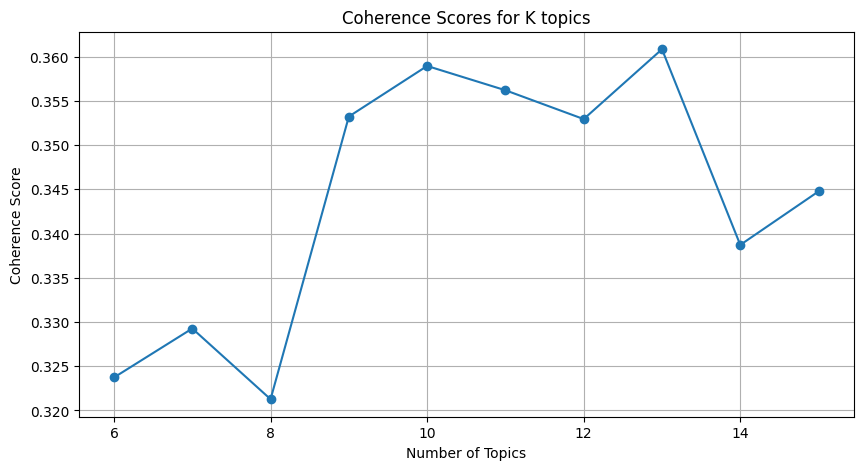

In [ ]:
import matplotlib.pyplot as plt

# Prepare the data
x = [score[0] for score in coherence_scores]  # number of topics
y = [score[1] for score in coherence_scores]  # coherence scores

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(x, y, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores for K topics")
plt.grid(True)
plt.show()

In [ ]:
print("Highest Coherence Score:", max(y))
print("With k topics:", x[y.index(max(y))])

Highest Coherence Score: 0.3608478662905656
With k topics: 13


In [ ]:
# ! pip install pyLDAvis

In [ ]:
# Visualize LDA
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary, mds="mmds", R=30)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8     -0.271192 -0.412748       1        1  8.872585
0     -0.183357  0.013170       2        1  8.407195
11    -0.476583  0.126391       3        1  8.195561
5      0.185163 -0.015655       4        1  7.831716
2     -0.011575 -0.343292       5        1  7.830524
6      0.126950  0.474354       6        1  7.759050
4     -0.054361  0.336090       7        1  7.542166
9     -0.305653  0.380743       8        1  7.483571
7     -0.423704 -0.184784       9        1  7.476753
12     0.171650 -0.467289      10        1  7.466962
1      0.407559 -0.257366      11        1  7.055886
3      0.473653  0.040135      12        1  7.042343
10     0.361449  0.310251      13        1  7.035687, topic_info=          Term         Freq        Total Category  logprob  loglift
79       polic  2299.000000  2299.000000  Default  30.0000  30.0000
68         new  1792.000000  1792.000000  Default  29.0000  29.0000
240        say  1589.000000  1589.000000  Default  28.0000  28.0000
46         man  1809.000000  1809.000000  Default  27.0000  27.0000
0        court  1202.000000  1202.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
950   pakistan   190.764089   191.821419  Topic13  -4.5779   2.6486
345     presid   185.005112   186.062441  Topic13  -4.6085   2.6485
336     scheme   181.731298   182.788628  Topic13  -4.6264   2.6484
1032       nrn   178.680778   179.738106  Topic13  -4.6433   2.6483
1455   program   178.341931   179.399262  Topic13  -4.6452   2.6483

[430 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
451       8  0.993184    abbott
461       6  0.998489       abc
686       6  0.994022  aborigin
1370      2  0.995231      abus
999       4  0.997690     accid
...     ...       ...       ...
422       8  0.997804      work
135       3  0.997459    worker
182       3  0.998750     world
746       2  0.998176      year
647       6  0.994098     young

[404 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 1, 12, 6, 3, 7, 5, 10, 8, 13, 2, 4, 11])

In [ ]:
topic_names = {1: 'Goverment-related',
               2:'Crime',
               3:'Elections',
               4:'Crime-cartels',
               5:'Police',
               6:'Sports',
               7:'Car accident',
               8:'Health',
               9:'Politics',
               10:'Health Policies',
               11:'Terrorism',
               12:'Law and Courts',
               13:'Jobs',
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Classify

In [ ]:
def classify_text(lda_model, text, dictionary):

    text = tokenize(text)

    bow = dictionary.doc2bow(text)
    topics = lda_model.get_document_topics(bow, minimum_probability=0)
    # Sort topics by probability
    topics = sorted(topics, key=lambda x: x[1], reverse=True)
    return topics[0][0] if topics else None  # Return the most probable topic's ID

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Apply the classification to each row in the DataFrame
df['cluster'] = df['headline_text'].apply(lambda text: classify_text(lda_model, text, dictionary))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for name, group in df.groupby('cluster'):

    topic = topic_names[int(name+1)]
    print(f"Cluster {topic}:")
    if len(group) > 10:
        print(group.sample(n=10))  # Randomly sample 10 entries to display
    else:
        print(group)  # If less than 10, print all
    print("\n")

Cluster Goverment-related:
       publish_date                                      headline_text  \
50410      20110707                        patterson silencing dissent   
29435      20141004  man yelled youre finished before machete attac...   
38934      20071106                                overboard man found   
61863      20080318           caroona coal challenge hearings continue   
42459      20101202      greens urge opposition to margaret river coal   
27712      20050425              axum obelisk completes return journey   
23888      20120418                                the culture quarter   
41067      20210128             indonesian volcano mount merapi erupts   
22339      20180326    one in four churchgoers domestic abuse research   
53868      20070515       man stabbed tourist with blood filled needle   

       cluster  
50410        0  
29435        0  
38934        0  
61863        0  
42459        0  
27712        0  
23888        0  
41067        0  
22339

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Visualize

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
# reduced_features = pca.fit_transform(X.toarray())
reduced_features = pca.fit_transform(document_embeddings)

# Plot each cluster
plt.figure(figsize=(10, 6))
for i in range(k):
    plt.scatter(reduced_features[unsupervised['cluster'] == i, 0], reduced_features[unsupervised['cluster'] == i, 1], label=f'Cluster {i+1}')

plt.legend()
plt.title('News Headlines Clustering')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.show()


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensions to 2D for visualization using t-SNE
tsne = TSNE(n_components=2, random_state=42)  # setting random_state for reproducibility
# reduced_features = tsne.fit_transform(X.toarray())
# reduced_features = tsne.fit_transform(document_embeddings)
reduced_features = tsne.fit_transform(documents)

# Plot each cluster
plt.figure(figsize=(10, 6))
for i in range(k):
    plt.scatter(reduced_features[df['cluster'] == i, 0], reduced_features[df['cluster'] == i, 1], label=f'Cluster {i+1}')

plt.legend()
plt.title('News Headlines Clustering using t-SNE')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()


# Top2Vec

In [ ]:
headlines = df['headline_text'].tolist()

In [ ]:
# !pip install top2vec
# !pip install top2vec[sentence_encoders]

In [ ]:
from top2vec import Top2Vec

model = Top2Vec(headlines, hdbscan_args={'min_cluster_size': 100, 'min_samples': 5})
topic_sizes, topic_nums = model.get_topic_sizes()

2024-05-12 07:14:56,233 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2024-05-12 07:15:00,568 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual model
2024-05-12 07:15:11,652 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2024-05-12 07:16:48,079 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2024-05-12 07:18:33,574 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarnin

In [ ]:
words, word_scores, nums = model.get_topics()
for topic in topic_nums:
    print(f"Topic {topic}:")
    print(words[topic-1])

Topic 0:
['drum' 'wednesday' 'thursday' 'friday' 'tuesday' 'september' 'november'
 'monday' 'october' 'week' 'weekend' 'march' 'july' 'august' 'april'
 'june' 'january' 'festival' 'month' 'quarter' 'blues' 'turnbull'
 'rockhampton' 'christmas' 'months' 'rock' 'days' 'beats' 'day' 'cyclone'
 'teen' 'chris' 'tour' 'date' 'rally' 'fourth' 'seven' 'year' 'night'
 'teenager' 'crackdown' 'funeral' 'season' 'late' 'bulls' 'bulldogs'
 'protesters' 'obama' 'teens' 'rain']
Topic 1:
['swans' 'swan' 'outback' 'crackdown' 'strike' 'apologises' 'defence'
 'caught' 'federer' 'quits' 'brawl' 'sacked' 'lockdown' 'drought' 'defeat'
 'hobart' 'survivors' 'manslaughter' 'fight' 'miss' 'bashing' 'drop'
 'rescued' 'beattie' 'turnbull' 'lost' 'bulldogs' 'rising' 'stabbed'
 'tony' 'reef' 'dead' 'robbery' 'underway' 'drops' 'darwin' 'grandstand'
 'stabbing' 'afl' 'deadly' 'raid' 'wins' 'dump' 'invasion' 'dam' 'backs'
 'crows' 'loses' 'funeral' 'fighting']
Topic 2:
['police' 'arrested' 'arrests' 'arrest' 'mansl

In [ ]:
print(len(topic_nums))
print(topic_sizes)
print(sum(topic_sizes))

98
[2282 1923 1683 1637 1594 1567 1547 1513 1494 1432 1371 1370 1338 1316
 1270 1252 1179 1001  970  960  949  806  800  787  783  769  752  749
  738  725  720  714  655  652  627  614  611  601  596  571  569  540
  534  530  522  519  493  486  483  473  473  462  461  443  406  396
  393  392  391  389  385  382  361  353  332  323  320  319  318  312
  308  290  290  287  278  278  275  271  268  266  265  252  251  240
  235  232  227  225  221  216  201  200  194  183  166  158  129  125]
62209


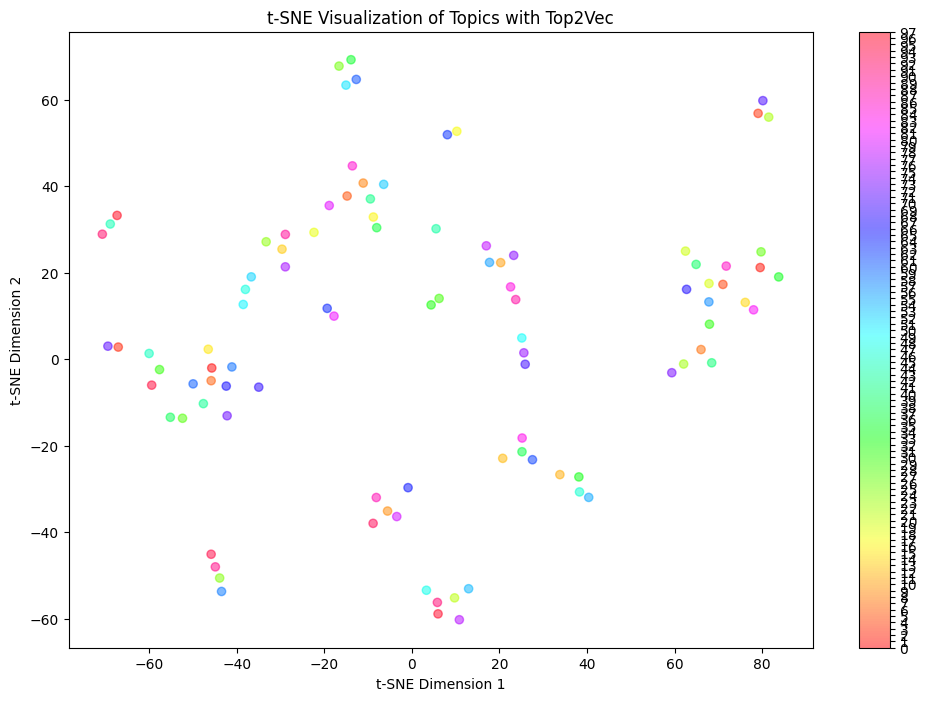

In [ ]:
import matplotlib.pyplot as plt

topic_sizes, topic_nums = model.get_topic_sizes()

# Generate topic reduced vectors
topic_vectors = model.topic_vectors

# Reduce dimensionality with t-SNE
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
tsne_values = tsne_model.fit_transform(topic_vectors)

# Plotting the t-SNE results
x = tsne_values[:, 0]
y = tsne_values[:, 1]

plt.figure(figsize=(12, 8))
plt.scatter(x, y, c=topic_nums, cmap='hsv', alpha=0.5)
plt.colorbar(ticks=range(len(set(topic_nums))))
plt.title('t-SNE Visualization of Topics with Top2Vec')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


# Merging clusters with AGNES

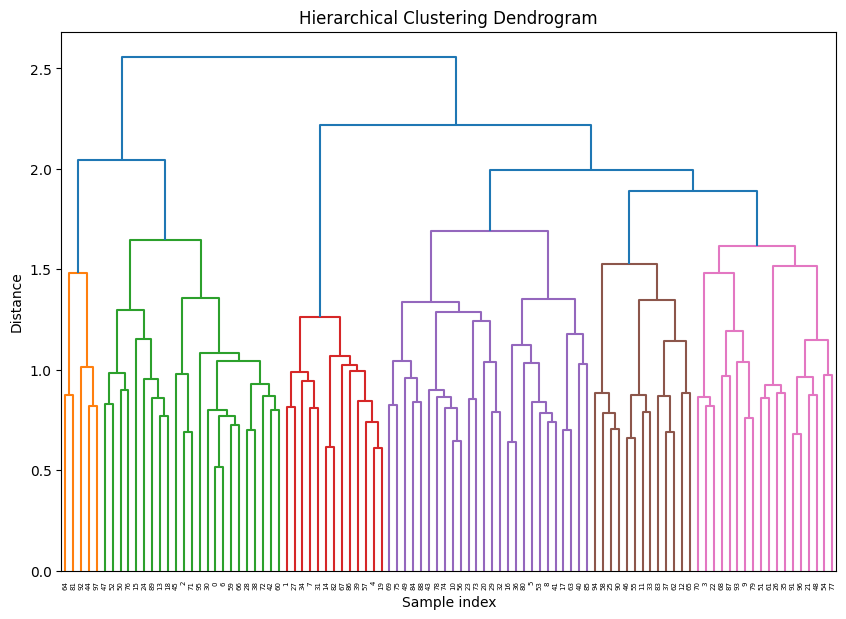

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [ ]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

Z = sch.linkage(topic_vectors, method='ward')  # Create the hierarchical clustering encoded as a linkage matrix

# Plot dendrogram to help decide on the number of clusters
plt.figure(figsize=(10, 7))
sch.dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

k = 13
# Apply Agglomerative Clustering to achieve the desired number of clusters
cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
cluster_labels = cluster.fit_predict(topic_vectors)

In [ ]:
# Create a mapping from new cluster labels to lists of original topic indices
from collections import defaultdict
new_clusters = defaultdict(list)
for idx, label in enumerate(cluster_labels):
    new_clusters[label].append(idx)

# Print out new cluster compositions
for cluster, topics in new_clusters.items():
    print(f"Cluster {cluster} consists of original topics: {topics}")


Cluster 0 consists of original topics: [0, 2, 6, 28, 30, 38, 42, 45, 59, 60, 66, 71, 72, 95]
Cluster 5 consists of original topics: [1, 4, 7, 14, 19, 27, 31, 34, 39, 57, 67, 82, 86]
Cluster 12 consists of original topics: [3, 22, 70]
Cluster 1 consists of original topics: [5, 8, 16, 17, 36, 40, 41, 53, 63, 80, 85]
Cluster 4 consists of original topics: [9, 68, 79, 87, 93]
Cluster 6 consists of original topics: [10, 20, 23, 29, 32, 43, 49, 56, 69, 73, 74, 75, 78, 84, 88]
Cluster 2 consists of original topics: [11, 12, 33, 37, 46, 55, 62, 65, 83]
Cluster 3 consists of original topics: [13, 15, 18, 24, 47, 50, 52, 76, 89]
Cluster 8 consists of original topics: [21, 48, 54, 77, 91, 96]
Cluster 9 consists of original topics: [25, 58, 90, 94]
Cluster 10 consists of original topics: [26, 35, 51, 61]
Cluster 7 consists of original topics: [44, 92, 97]
Cluster 11 consists of original topics: [64, 81]


In [ ]:
def update_vocab(topics):

  vocab = []

  for topic_index in topics:
    words, word_scores, _ = model.get_topics()
    words = words[topic_index]

    for word in words:
      vocab.append(word)

  return vocab

words = {}

# For each new cluster, find and print the most representative words
for cluster_id, topic_indices in new_clusters.items():
  words[cluster_id] = update_vocab(topic_indices)
  print(f"Cluster {cluster_id}: {words[cluster_id]}")



Cluster 0: ['swans', 'swan', 'outback', 'crackdown', 'strike', 'apologises', 'defence', 'caught', 'federer', 'quits', 'brawl', 'sacked', 'lockdown', 'drought', 'defeat', 'hobart', 'survivors', 'manslaughter', 'fight', 'miss', 'bashing', 'drop', 'rescued', 'beattie', 'turnbull', 'lost', 'bulldogs', 'rising', 'stabbed', 'tony', 'reef', 'dead', 'robbery', 'underway', 'drops', 'darwin', 'grandstand', 'stabbing', 'afl', 'deadly', 'raid', 'wins', 'dump', 'invasion', 'dam', 'backs', 'crows', 'loses', 'funeral', 'fighting', 'australian', 'australias', 'australians', 'australia', 'aussies', 'aussie', 'cricket', 'afl', 'india', 'gippsland', 'aboriginal', 'pakistan', 'tasmania', 'rugby', 'sydney', 'adelaide', 'melbourne', 'tasmanian', 'afghanistan', 'aust', 'indonesian', 'nz', 'indigenous', 'british', 'darwin', 'indonesia', 'pacific', 'indian', 'england', 'overseas', 'brisbane', 'reef', 'commonwealth', 'wallabies', 'asylum', 'bali', 'anzac', 'uk', 'international', 'bush', 'nationals', 'iraqi', 'n

# tf-idf

In [ ]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

documents = [' '.join(words_list) for words_list in words.values()]

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()

def get_top_keywords(tfidf_scores, features, docs, top_n=10):
    sorted_keywords = {}
    for i, doc_name in enumerate(docs.keys()):
        # Get the tf-idf array for each document
        doc_scores = tfidf_scores[i, :].toarray().flatten()

        # Sort indices by score in descending order
        sorted_indices = np.argsort(doc_scores)[::-1]

        # Get the top n indices with the highest scores
        top_feature_indices = sorted_indices[:top_n]

        # Map indices to feature names and their corresponding scores
        top_features = [(features[index], doc_scores[index]) for index in top_feature_indices if doc_scores[index] > 0]

        # Store in dictionary under the original document name
        sorted_keywords[doc_name] = top_features

    return sorted_keywords

# Get top keywords for each document
top_keywords_per_document = get_top_keywords(tfidf_matrix, feature_names, words, top_n=50)


In [ ]:
for doc_name, keywords in top_keywords_per_document.items():
    print(f"{doc_name}:")
    for feature, score in keywords:
        print(f"  {feature}: {score:.4f}")
    print("\n")


0:
  loses: 0.2326
  afl: 0.2042
  rugby: 0.2006
  cricket: 0.1956
  broncos: 0.1923
  bulldogs: 0.1750
  outback: 0.1605
  football: 0.1605
  wins: 0.1604
  win: 0.1423
  defeat: 0.1423
  hawks: 0.1404
  brawl: 0.1404
  socceroos: 0.1395
  league: 0.1395
  federer: 0.1354
  finals: 0.1282
  eagles: 0.1245
  united: 0.1203
  turnbull: 0.1203
  team: 0.1163
  players: 0.1163
  australians: 0.1138
  olympic: 0.1122
  defence: 0.1108
  grandstand: 0.1069
  swans: 0.1069
  knights: 0.1067
  captain: 0.1021
  newcastle: 0.1003
  warriors: 0.1003
  darwin: 0.0985
  olympics: 0.0961
  beattie: 0.0936
  sacked: 0.0911
  australian: 0.0911
  england: 0.0889
  coach: 0.0889
  rockhampton: 0.0889
  aussies: 0.0875
  tony: 0.0802
  adelaide: 0.0802
  melbourne: 0.0802
  sydney: 0.0802
  lost: 0.0801
  aussie: 0.0801
  cowboys: 0.0801
  australias: 0.0739
  glory: 0.0711
  commissioner: 0.0711


5:
  crime: 0.2092
  victims: 0.2092
  rape: 0.2052
  prison: 0.1728
  allegations: 0.1728
  alleged: 0.